## Import functions and constants

let functions defined in `main_code/` (and elsewhere) update automatically

In [37]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import warnings
from main_code import (
    adjust_calibration, bh_mass,
    d4000_lick_indices, data_reading,
    difference, gaussian_fitting,
    helpers, integrate,
    plotting, polynomial_fit,
    qsofit
)
import main_code.constants as const

import matplotlib.pyplot as plt

In [39]:
plt.rcParams.update({'font.size': const.TEXT_SIZE}) # default is 10

Redirect and supress specific warnings

In [40]:
# Redirect warnings to stdout
warnings.showwarning = lambda msg, *args: print(f"WARNING: {msg}", flush=True)

warnings.filterwarnings("ignore", message="All-NaN slice encountered")
warnings.filterwarnings("ignore", message="Polyfit may be poorly conditioned")
warnings.filterwarnings("ignore", message="Spectres: new_wavs contains values outside")

## Load in, blur and resample the data

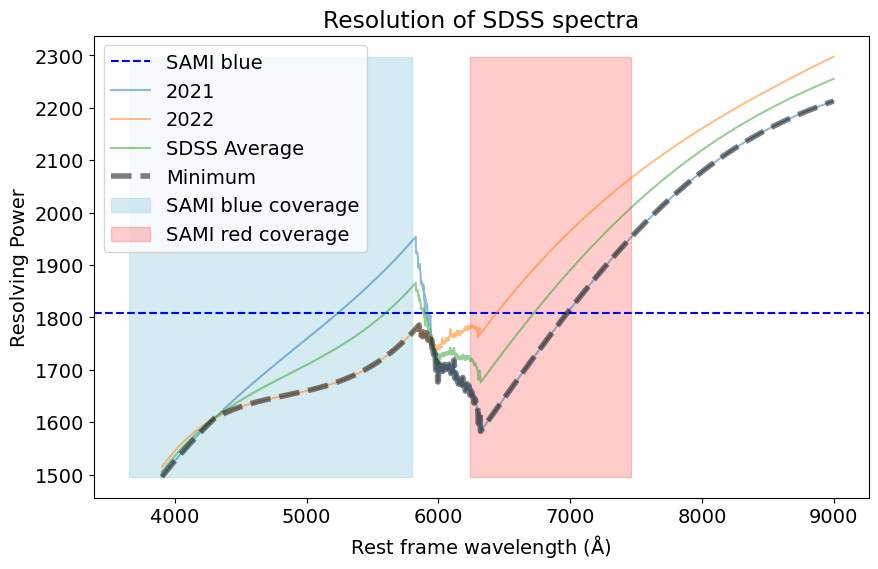

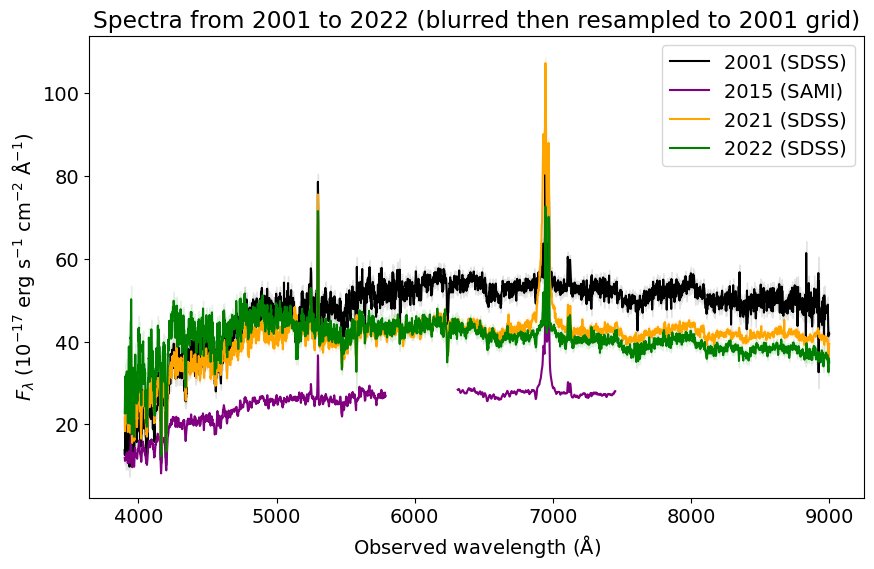

In [41]:
zoom = (6900, 7000)

data = data_reading.get_adjusted_data(
    blur_before_resampling=True,
    # as_is_xlim=zoom,
    # clipped_xlim=zoom,
    # blurred_xlim=zoom,
    # resampled_xlim=zoom,
    # resampled_and_blurred_xlim=zoom,
    plot_res_coverage=True,
    plot_errors=True
)
unadjusted_data = data_reading.get_adjusted_data(return_as_is=True)

(
    (ua_lam01, ua_flux01, ua_err01),
    (ua_lam15_blue, ua_flux15_blue, ua_err15_blue),
    (ua_lam15_red, ua_flux15_red, ua_err15_red),
    (ua_lam21, ua_flux21, ua_err21),
    (ua_lam22, ua_flux22, ua_err22)
) = unadjusted_data

lam, (data01, data15, data21, data22) = data
flux01, err01 = data01
flux15, err15 = data15
flux21, err21 = data21
flux22, err22 = data22

Check D4000 and lick indices

In [42]:
d4000_lick_indices.get_results(
    [ua_lam01, ua_lam15_blue, ua_lam21, ua_lam22],
    [ua_flux01, ua_flux15_blue, ua_flux21, ua_flux22],
    [ua_err01**2, ua_err15_blue**2, ua_err21**2, ua_err22**2],
    years=["2001", "2015", "2021", "2022"],
    idx_names=["D4000", "Hbeta", "Mg_b", "Fe4383"],
    print_results=True
);

D4000 for 2001: 1.646 ± 0.015
D4000 for 2015: 1.471 ± 0.001
D4000 for 2021: 1.480 ± 0.007
D4000 for 2022: 1.479 ± 0.011

Hbeta for 2001: 2.661 ± 0.726
Hbeta for 2015: 0.168 ± 0.002
Hbeta for 2021: -0.179 ± 0.030
Hbeta for 2022: 1.744 ± 0.461

Mg_b for 2001: 2.678 ± 0.802
Mg_b for 2015: 1.903 ± 0.027
Mg_b for 2021: 2.447 ± 0.487
Mg_b for 2022: 2.327 ± 0.688

Fe4383 for 2001: 4.106 ± 2.197
Fe4383 for 2015: 3.643 ± 0.100
Fe4383 for 2021: 3.932 ± 1.270
Fe4383 for 2022: 3.734 ± 1.879



## Qualitatively inspecting a sensible region of Balmer emission to ignore

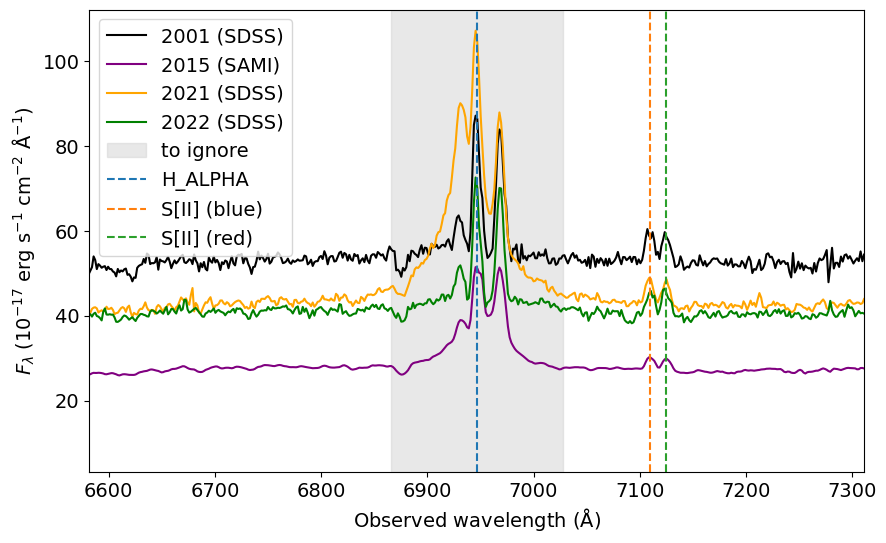

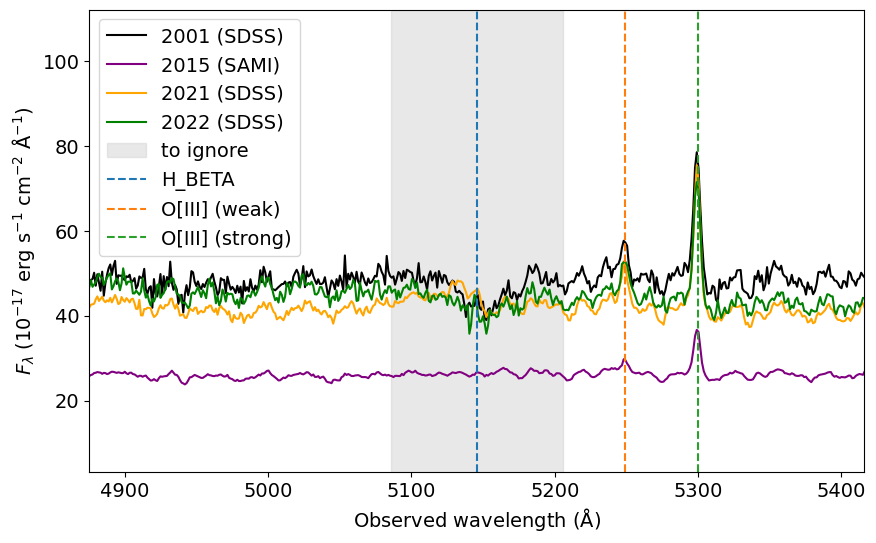

Width of wavelengths to ignore around Hα: 162.20 Å
Width of wavelengths to ignore around Hβ: 120.15 Å


In [43]:
plot_width_vel = const.VEL_PLOT_WIDTH * 1.5
selection_width_vel = const.VEL_TO_IGNORE_WIDTH

h_alpha_lam_bounds = helpers.get_lam_bounds(const.H_ALPHA, selection_width_vel, width_is_vel=True)
h_beta_lam_bounds = helpers.get_lam_bounds(const.H_BETA, selection_width_vel, width_is_vel=True)
# plot_width_ang = 400

plotting.plot_spectra(
    lam, lam, lam, lam,
    flux01,
    flux15,
    flux21,
    flux22,
    plot_errors=False,
    ions = {"H_ALPHA": const.H_ALPHA, "S[II] (blue)": const.SII_BLUE, "S[II] (red)": const.SII_RED},
    x_bounds = helpers.get_lam_bounds(const.H_ALPHA, plot_width_vel, width_is_vel=True),
    fill_between_bounds=h_alpha_lam_bounds,
    fill_between_label="to ignore",
    legend_loc="upper left"
)

plotting.plot_spectra(
    lam, lam, lam, lam,
    flux01,
    flux15,
    flux21,
    flux22,
    plot_errors=False,
    ions = {"H_BETA": const.H_BETA, "O[III] (weak)": const.OIII_WEAK, "O[III] (strong)": const.OIII_STRONG},
    x_bounds = helpers.get_lam_bounds(const.H_BETA, plot_width_vel, width_is_vel=True),
    fill_between_bounds=h_beta_lam_bounds,
    fill_between_label="to ignore",
    legend_loc="upper left"
)

print(f"Width of wavelengths to ignore around Hα: {h_alpha_lam_bounds[1] - h_alpha_lam_bounds[0]:.2f} Å")
print(f"Width of wavelengths to ignore around Hβ: {h_beta_lam_bounds[1] - h_beta_lam_bounds[0]:.2f} Å")

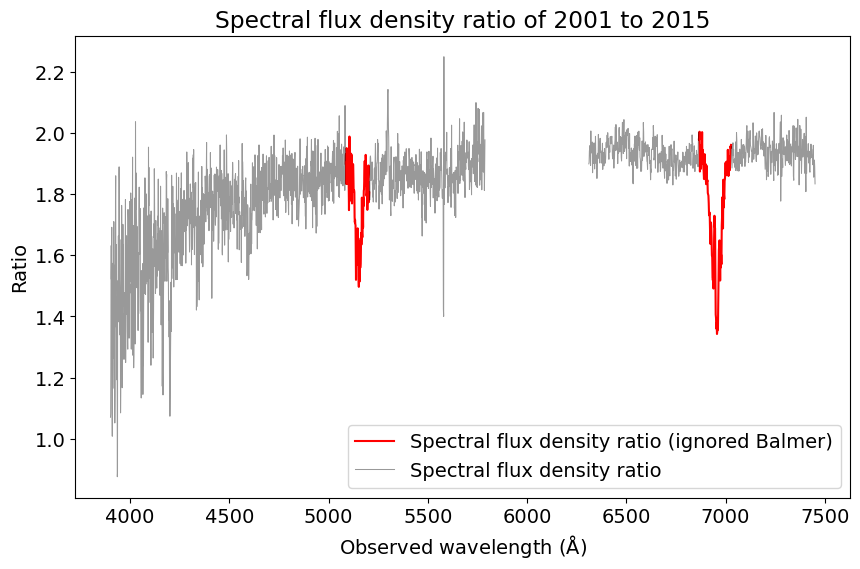

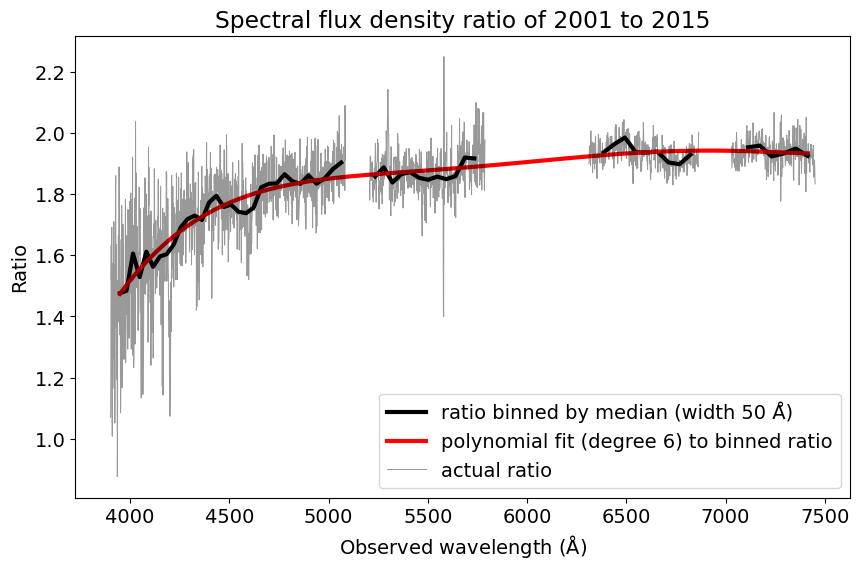

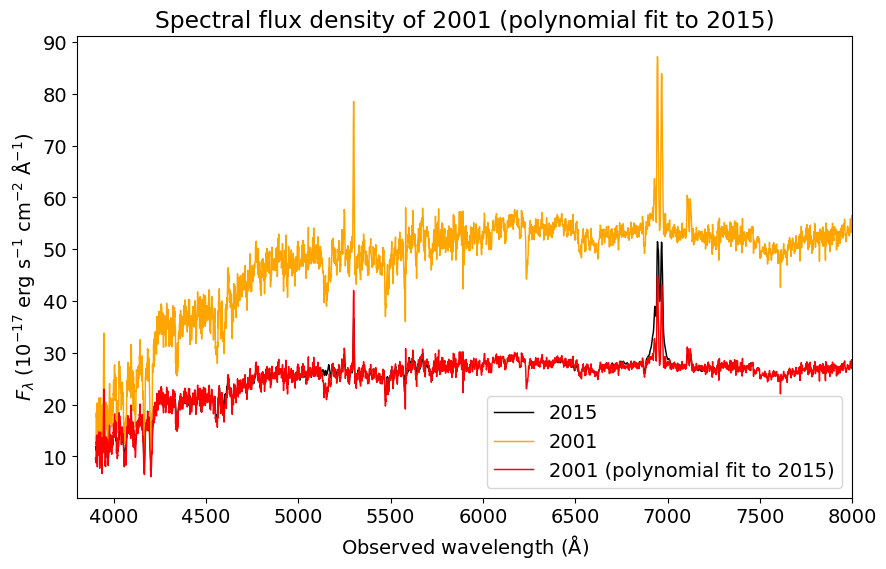

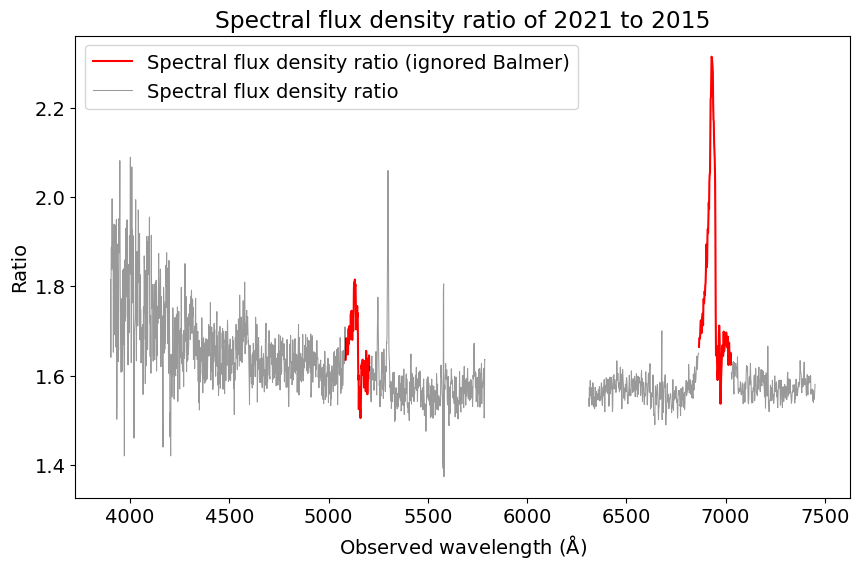

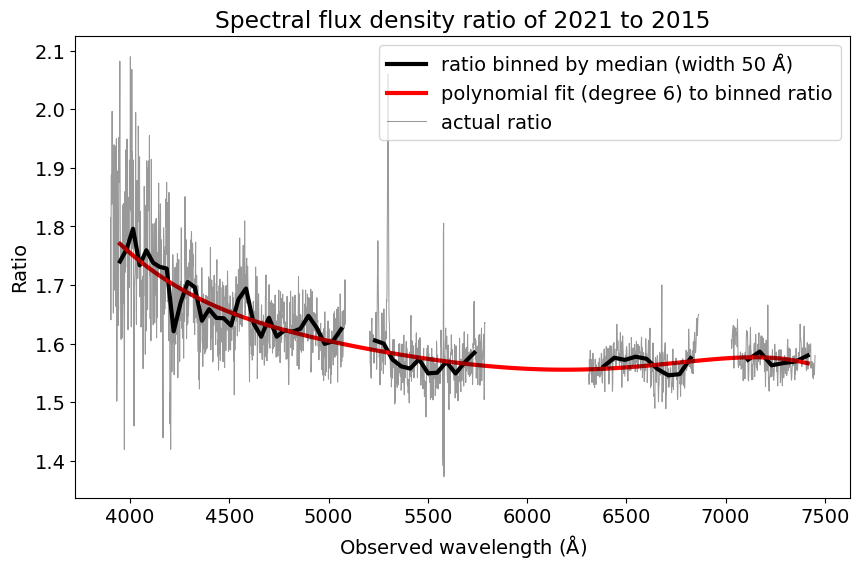

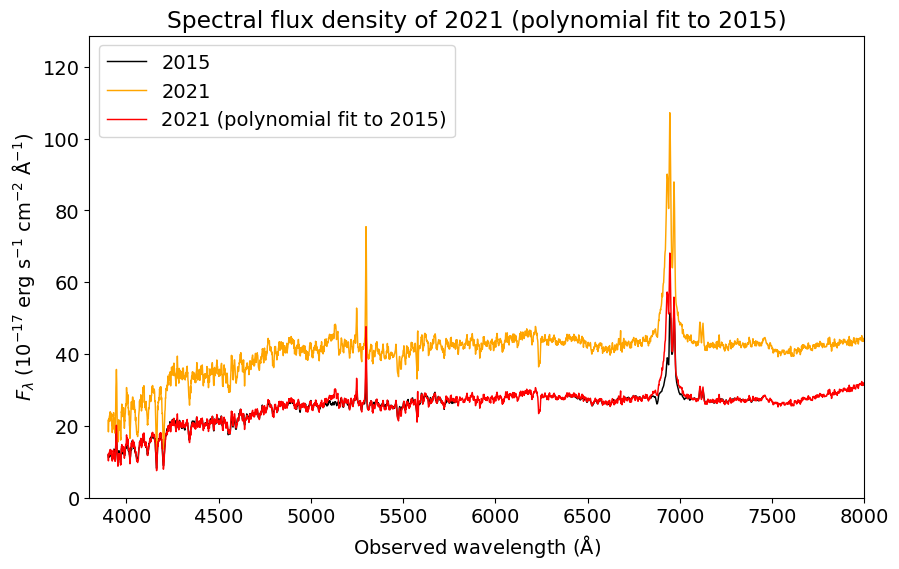

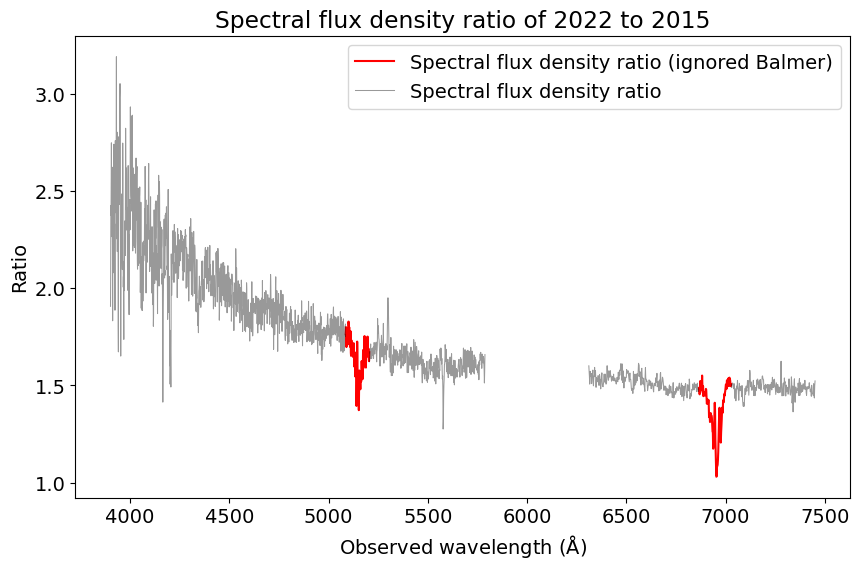

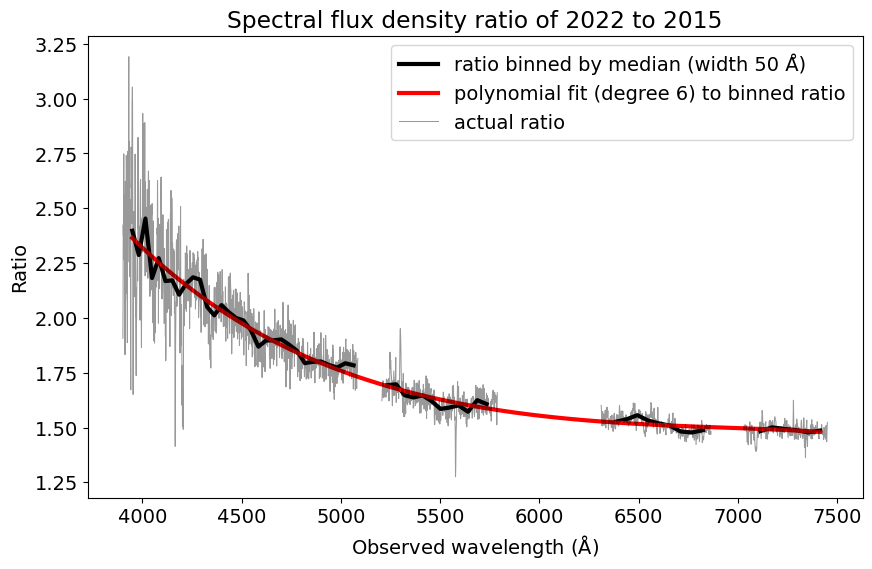

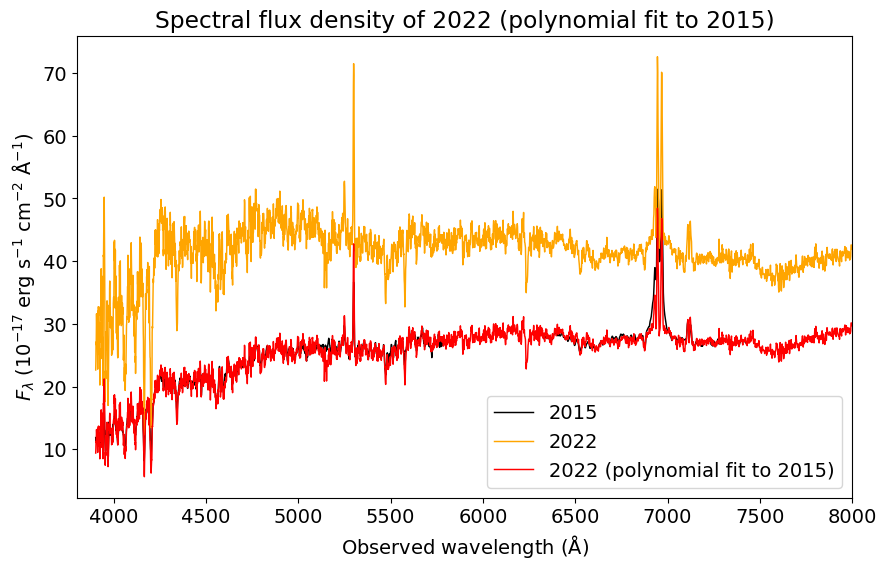

In [69]:
_, adjusted_01_flux_15, adjusted_01_err_15 = polynomial_fit.apply_poly_fit(data=data, year_to_adjust=2001)
# same as adjusted_15_flux_15, adjusted_15_err_15 = flux15, err15
_, adjusted_15_flux_15, adjusted_15_err_15 = polynomial_fit.apply_poly_fit(data=data, year_to_adjust=2015)
#
_, adjusted_21_flux_15, adjusted_21_err_15 = polynomial_fit.apply_poly_fit(data=data, year_to_adjust=2021)
_, adjusted_22_flux_15, adjusted_22_err_15 = polynomial_fit.apply_poly_fit(data=data, year_to_adjust=2022)

## Check polynomial fitted spectra and uncertainties around H-$\alpha$

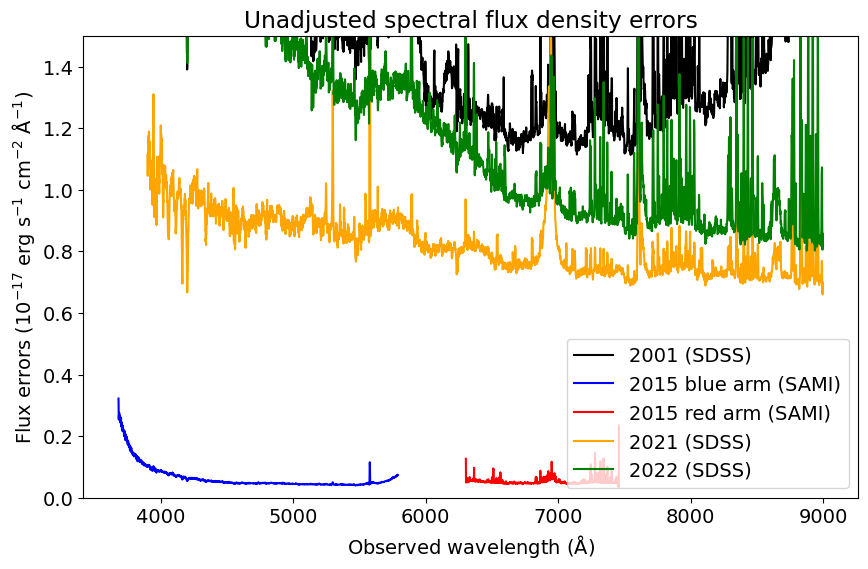

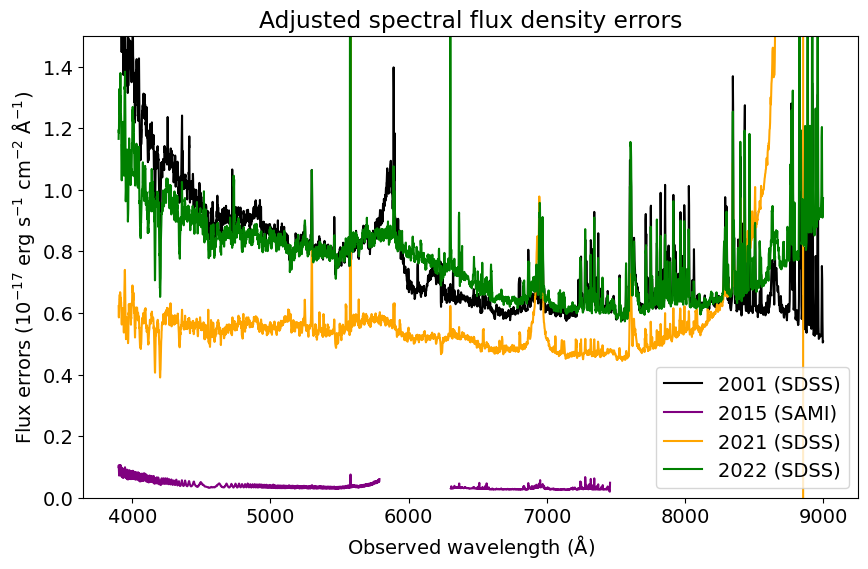

In [45]:
plotting.plot_spectra(
    ua_lam01, (ua_lam15_blue, ua_lam15_red), ua_lam21, ua_lam22,
    flux01=ua_err01,
    flux15=(ua_err15_blue, ua_err15_red),
    flux21=ua_err21,
    flux22=ua_err22,
    # x_bounds=h_alpha_lam_bounds,
    y_bounds=(0, 1.5),
    y_axis_label=f"Flux errors ({const.SFD_UNITS})",
    title=f"Unadjusted spectral flux density errors"
)

plotting.plot_spectra(
    lam, lam, lam, lam,
    flux01=adjusted_01_err_15,
    flux15=adjusted_15_err_15,
    flux21=adjusted_21_err_15,
    flux22=adjusted_22_err_15,
    # x_bounds=h_alpha_lam_bounds,
    y_bounds=(0, 1.5),
    y_axis_label=f"Flux errors ({const.SFD_UNITS})",
    title=f"Adjusted spectral flux density errors"
)


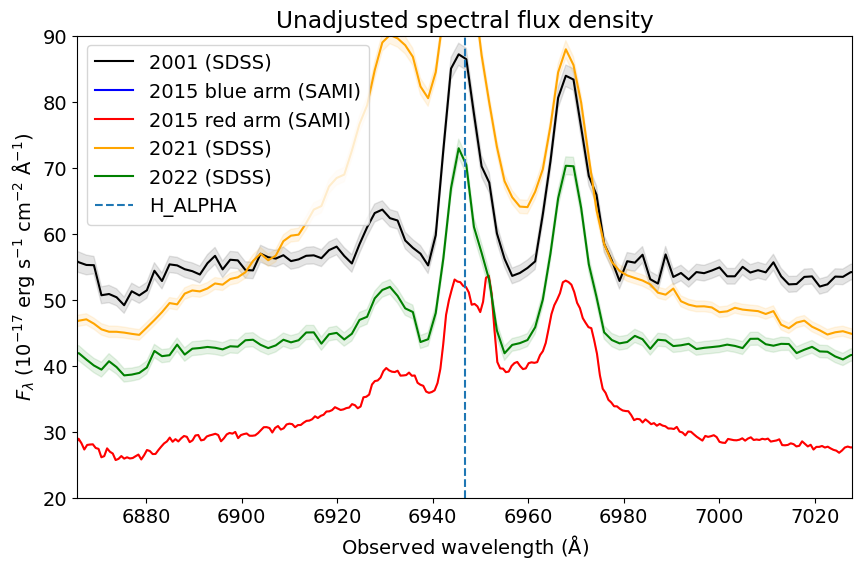

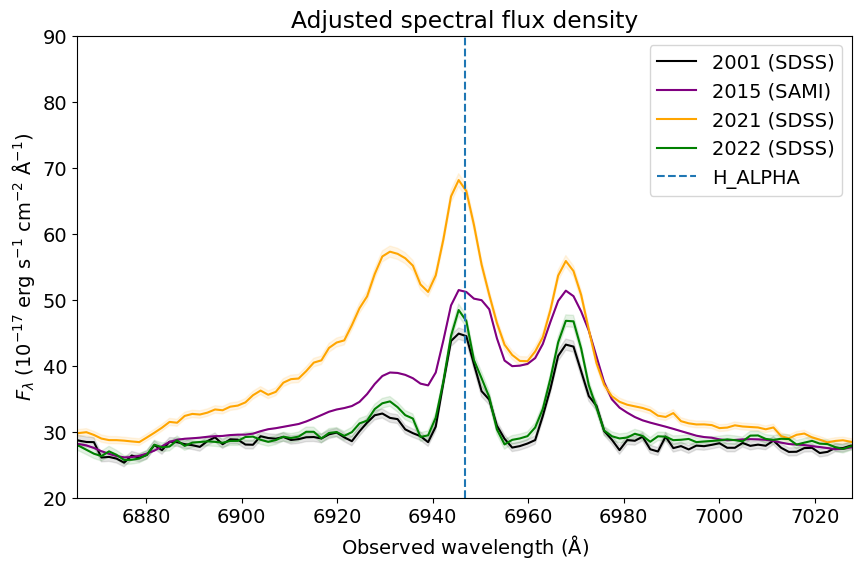

In [46]:
y_bounds = (20, 90)

plotting.plot_spectra(
    ua_lam01, (ua_lam15_blue, ua_lam15_red), ua_lam21, ua_lam22,
    ua_flux01,
    (ua_flux15_blue, ua_flux15_red),
    ua_flux21,
    ua_flux22,
    plot_errors=True,
    flux01_err=ua_err01,
    flux15_err=(ua_err15_blue, ua_err15_red),
    flux21_err=ua_err21,
    flux22_err=ua_err22,
    x_bounds=h_alpha_lam_bounds,
    y_bounds=y_bounds,
    ions = {"H_ALPHA": const.H_ALPHA},
    title=f"Unadjusted spectral flux density"
)

plotting.plot_spectra(
    lam, lam, lam, lam,
    adjusted_01_flux_15,
    adjusted_15_flux_15,
    adjusted_21_flux_15,
    adjusted_22_flux_15,
    plot_errors=True,
    flux01_err=adjusted_01_err_15,
    flux15_err=adjusted_15_err_15,
    flux21_err=adjusted_21_err_15,
    flux22_err=adjusted_22_err_15,
    x_bounds=h_alpha_lam_bounds,
    y_bounds=y_bounds,
    ions = {"H_ALPHA": const.H_ALPHA},
    title=f"Adjusted spectral flux density"
)

## Difference spectra

In [47]:
(diff_15_4arcsec, diff_21_4arcsec, diff_22_4arcsec), (diff_15_4arcsec_err, diff_21_4arcsec_err, diff_22_4arcsec_err), lam = difference.get_diff_spectra(return_lam=True,arcsec=4)

In [48]:
(diff_15, diff_21, diff_22), (diff_15_err, diff_21_err, diff_22_err), lam = difference.get_diff_spectra(return_lam=True)

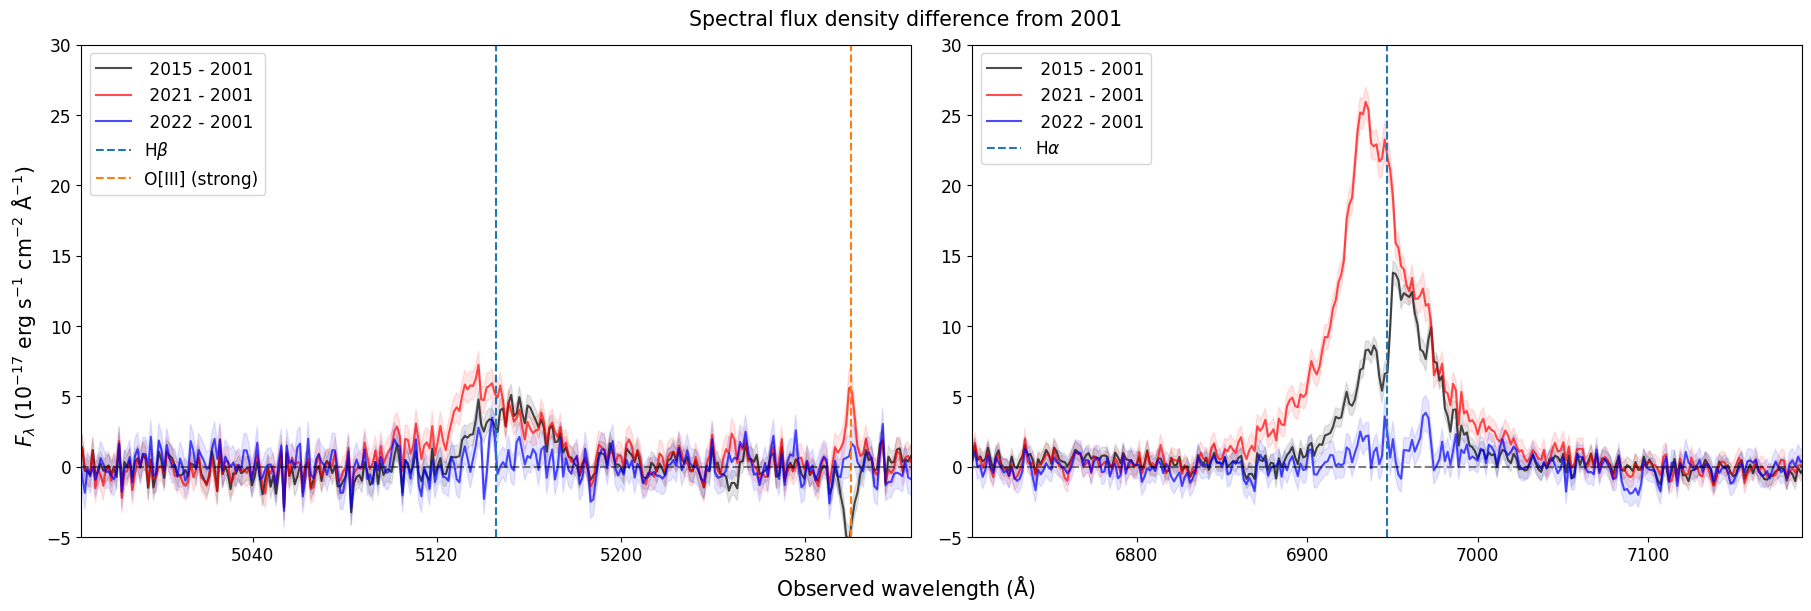

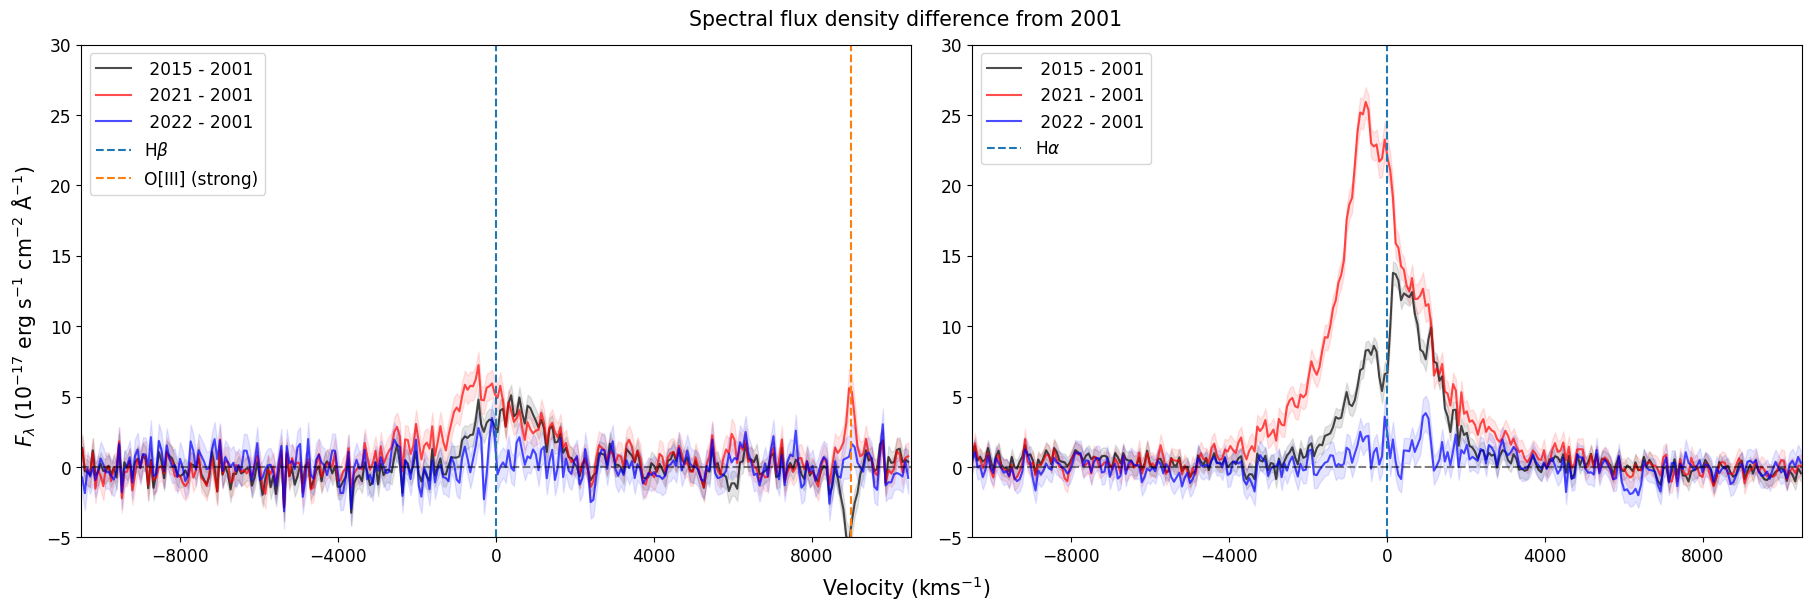

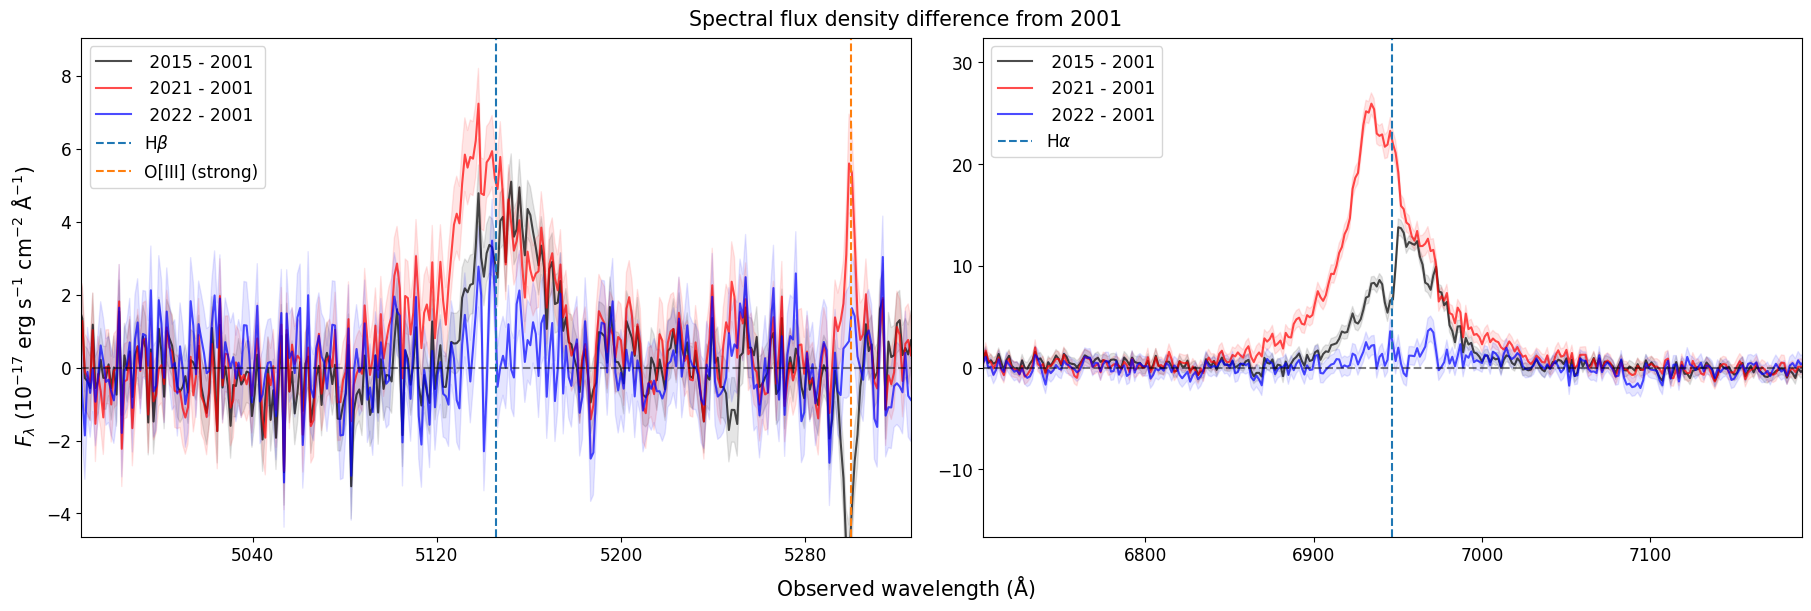

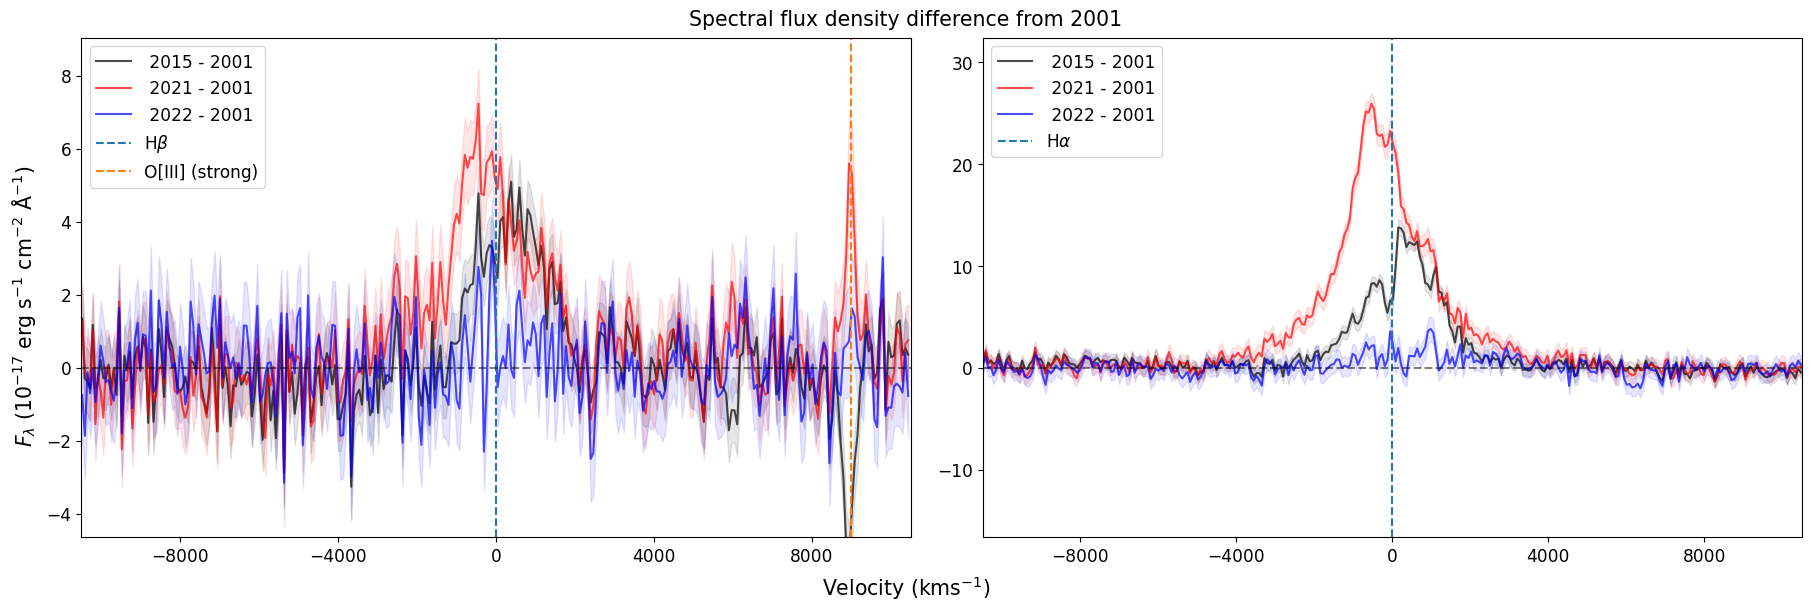

In [25]:
plt.rcParams.update({'font.size': const.DOUBLE_TEXT_SIZE})
plotting.plot_diff_spectra_all(
    lam=lam,
    diff_15=diff_15,
    diff_21=diff_21,
    diff_22=diff_22,
    diff_15_err=diff_15_err,
    diff_21_err=diff_21_err,
    diff_22_err=diff_22_err,
    figsize=const.DOUBLE_FIG_SIZE,
    scale_all_axes=False,
    use_ang_x_axis=True,
    # plot_y_bounds_list=[True, True],
    plot_y_bounds_list=[(-5, 30), (-5, 30)],
    save_fig_name="diff_all_epochs_unscaled_ang.pdf"
)
plotting.plot_diff_spectra_all(
    lam=lam,
    diff_15=diff_15,
    diff_21=diff_21,
    diff_22=diff_22,
    diff_15_err=diff_15_err,
    diff_21_err=diff_21_err,
    diff_22_err=diff_22_err,
    figsize=const.DOUBLE_FIG_SIZE,
    scale_all_axes=False,
    # use_ang_x_axis=True,
    # plot_y_bounds_list=[True, True],
    plot_y_bounds_list=[(-5, 30), (-5, 30)],
    save_fig_name="diff_all_epochs_unscaled_vel.pdf"
)
plotting.plot_diff_spectra_all(
    lam=lam,
    diff_15=diff_15,
    diff_21=diff_21,
    diff_22=diff_22,
    diff_15_err=diff_15_err,
    diff_21_err=diff_21_err,
    diff_22_err=diff_22_err,
    figsize=const.DOUBLE_FIG_SIZE,
    # scale_all_axes=False,
    use_ang_x_axis=True,
    # plot_y_bounds_list=[True, True],
    # plot_y_bounds_list=[(-5, 30), (-5, 30)],
    save_fig_name="diff_all_epochs_scaled_ang.pdf"
)
plotting.plot_diff_spectra_all(
    lam=lam,
    diff_15=diff_15,
    diff_21=diff_21,
    diff_22=diff_22,
    diff_15_err=diff_15_err,
    diff_21_err=diff_21_err,
    diff_22_err=diff_22_err,
    figsize=const.DOUBLE_FIG_SIZE,
    # scale_all_axes=False,
    # use_ang_x_axis=True,
    # plot_y_bounds_list=[True, True],
    # plot_y_bounds_list=[(-5, 30), (-5, 30)],
    save_fig_name="diff_all_epochs_scaled_vel.pdf"
)
plt.rcParams.update({'font.size': const.TEXT_SIZE})

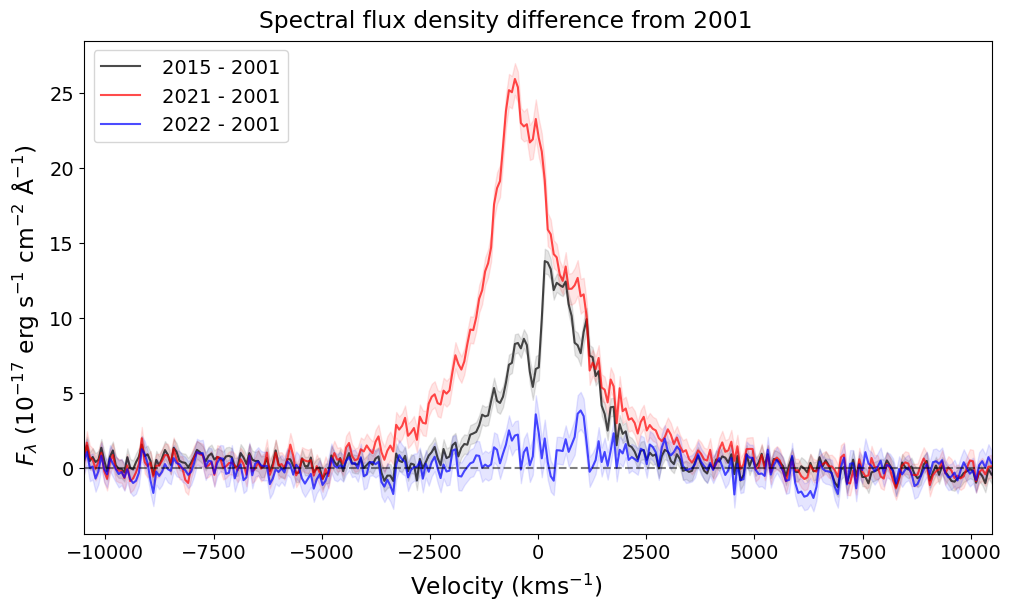

In [50]:
plotting.plot_diff_spectra_all(
    lam=lam,
    diff_15=diff_15,
    diff_21=diff_21,
    diff_22=diff_22,
    diff_15_err=diff_15_err,
    diff_21_err=diff_21_err,
    diff_22_err=diff_22_err,
    plot_labels_list=[None],
    # use_ang_x_axis=True,
    plot_centres_list=[const.H_ALPHA],
    ions_list=[None],
    scale_all_axes=False,
    n_ticks_x_list=[None],
    scale_axes_list=[False],
    plot_y_bounds_list=[False],
    save_fig_name="h_alpha_diff_all_epochs_vel.pdf"
)

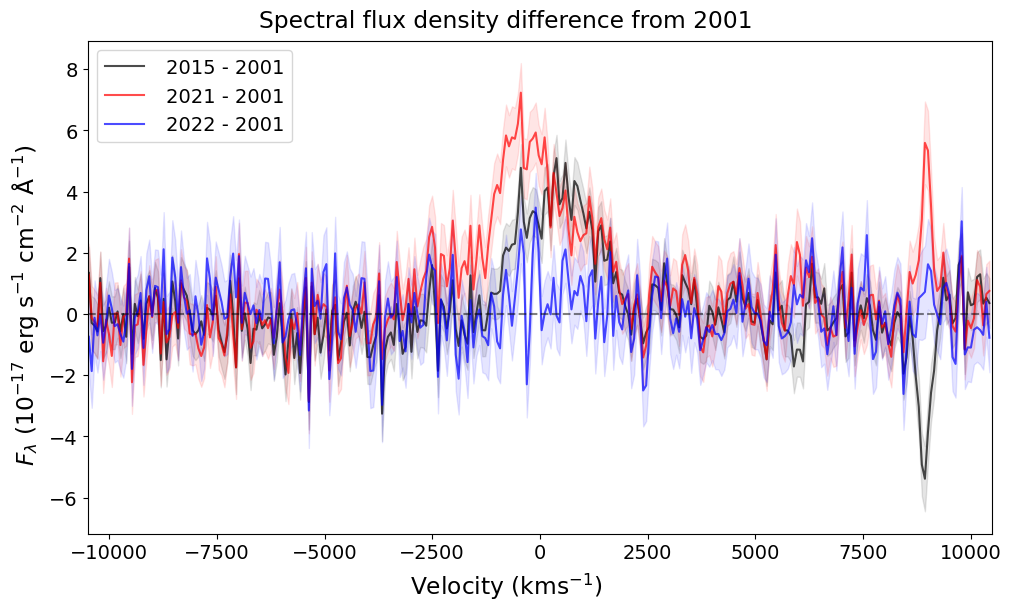

In [51]:
plotting.plot_diff_spectra_all(
    lam=lam,
    diff_15=diff_15,
    diff_21=diff_21,
    diff_22=diff_22,
    diff_15_err=diff_15_err,
    diff_21_err=diff_21_err,
    diff_22_err=diff_22_err,
    plot_labels_list=[None],
    # use_ang_x_axis=True,
    plot_centres_list=[const.H_BETA],
    ions_list=[None],
    scale_all_axes=False,
    n_ticks_x_list=[None],
    scale_axes_list=[False],
    plot_y_bounds_list=[False],
    save_fig_name="h_beta_diff_all_epochs_vel.pdf"
)

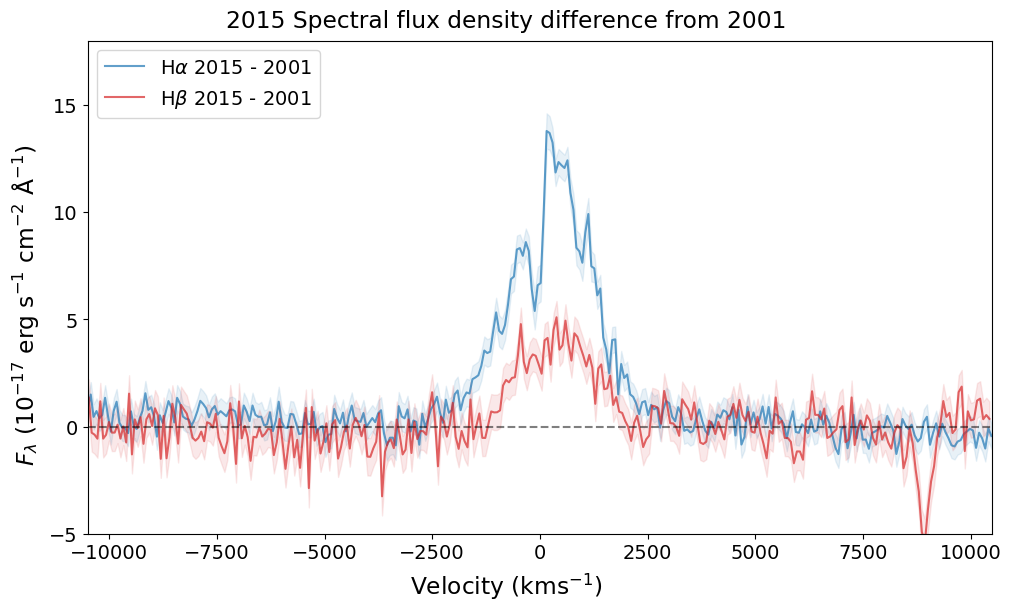

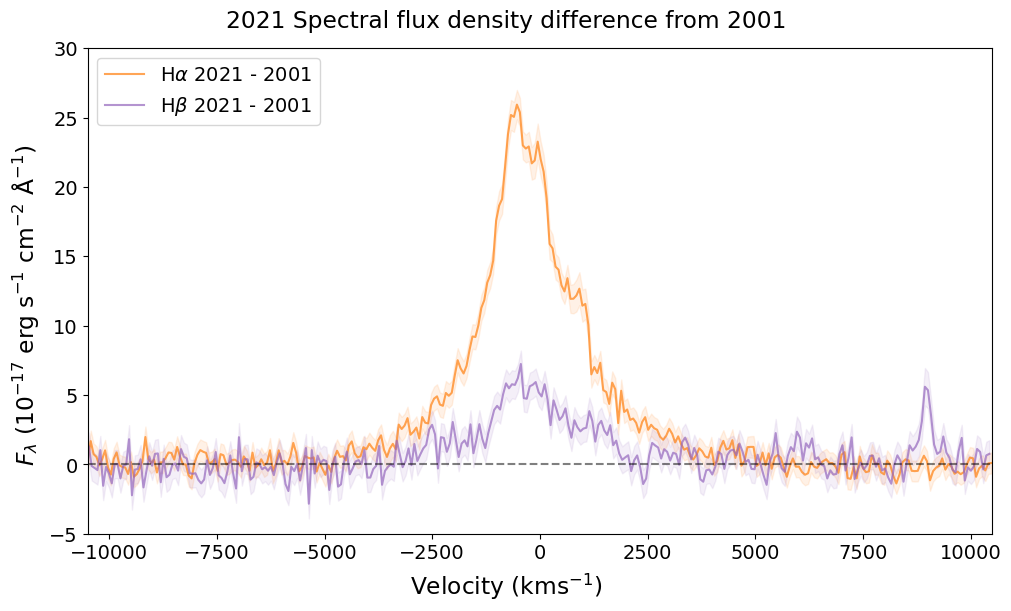

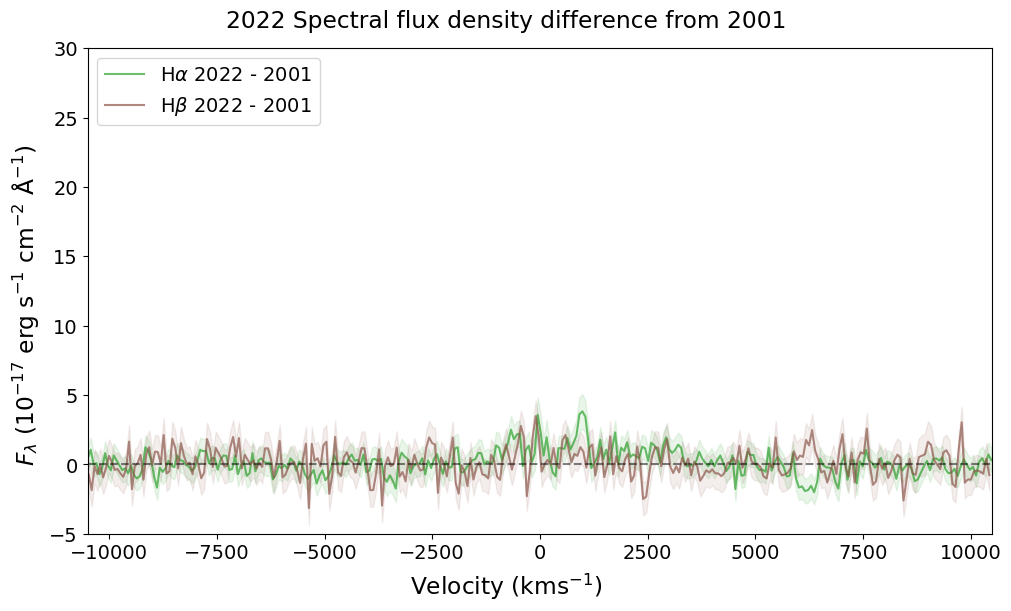

In [52]:
plotting.plot_diff_spectra_all(
    lam=lam,
    diff_15=diff_15,
    diff_15_err=diff_15_err,
    plot_y_bounds_list=[(-5, 18)],
    plot_centres_list=[[const.H_ALPHA, const.H_BETA]],
    plot_labels_list=[[r"H$\alpha$", r"H$\beta$"]],
    ions_list=[None],
    n_ticks_x_list=[None],
    scale_axes_list=[False],
    scale_all_axes=False,
    save_fig_name="diff_15_unscaled_vel.pdf"
)
plotting.plot_diff_spectra_all(
    lam=lam,
    diff_21=diff_21,
    diff_21_err=diff_21_err,
    plot_y_bounds_list=[(-5, 30)],
    plot_centres_list=[[const.H_ALPHA, const.H_BETA]],
    plot_labels_list=[[r"H$\alpha$", r"H$\beta$"]],
    ions_list=[None],
    n_ticks_x_list=[None],
    scale_axes_list=[False],
    scale_all_axes=False,
    save_fig_name="diff_21_unscaled_vel.pdf"
)
plotting.plot_diff_spectra_all(
    lam=lam,
    diff_22=diff_22,
    diff_22_err=diff_22_err,
    plot_y_bounds_list=[(-5, 30)],
    plot_centres_list=[[const.H_ALPHA, const.H_BETA]],
    plot_labels_list=[[r"H$\alpha$", r"H$\beta$"]],
    ions_list=[None],
    n_ticks_x_list=[None],
    scale_axes_list=[False],
    scale_all_axes=False,
    save_fig_name="diff_22_unscaled_vel.pdf"
)

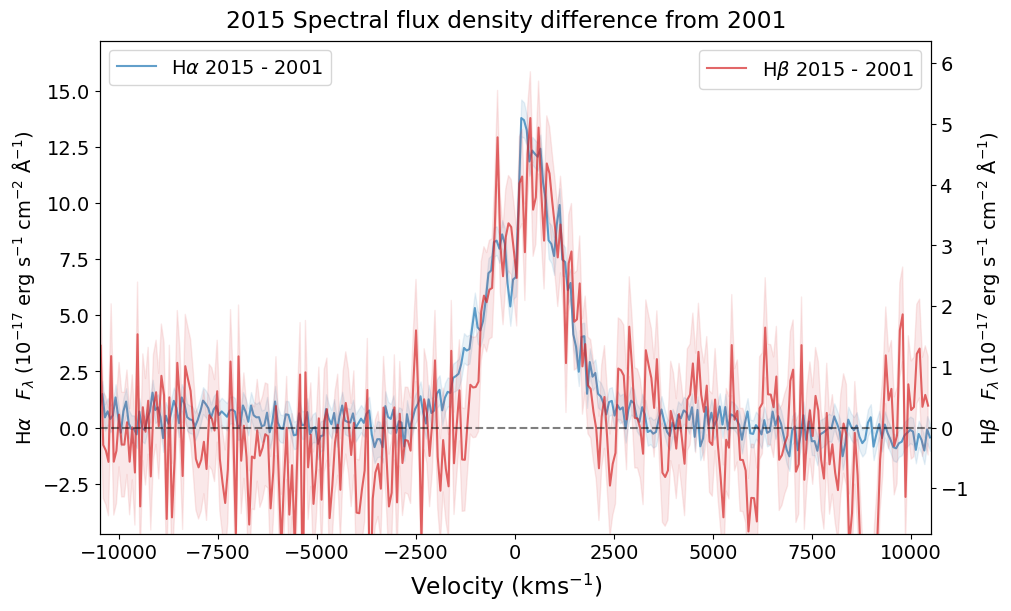

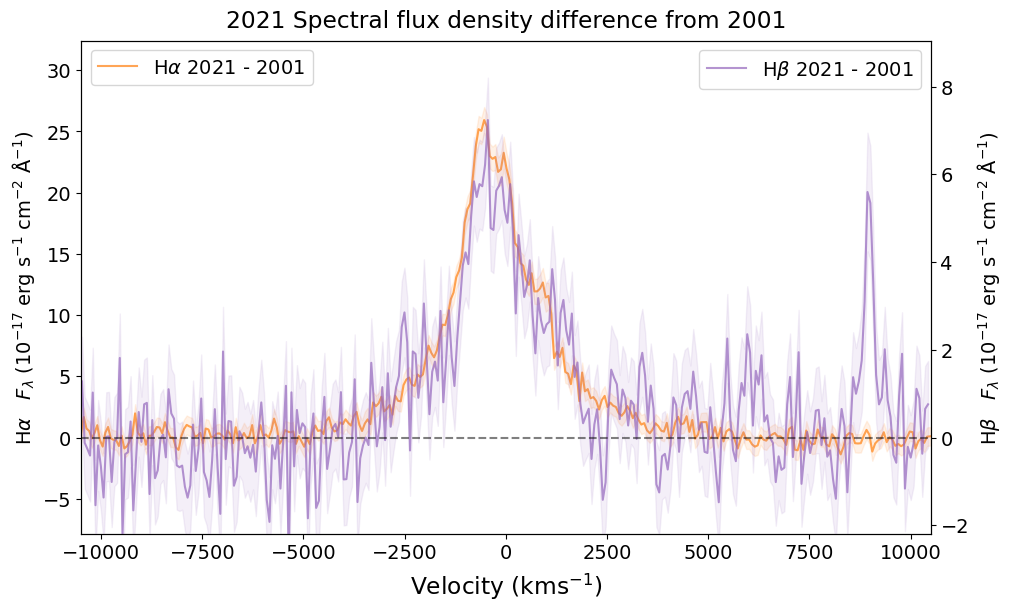

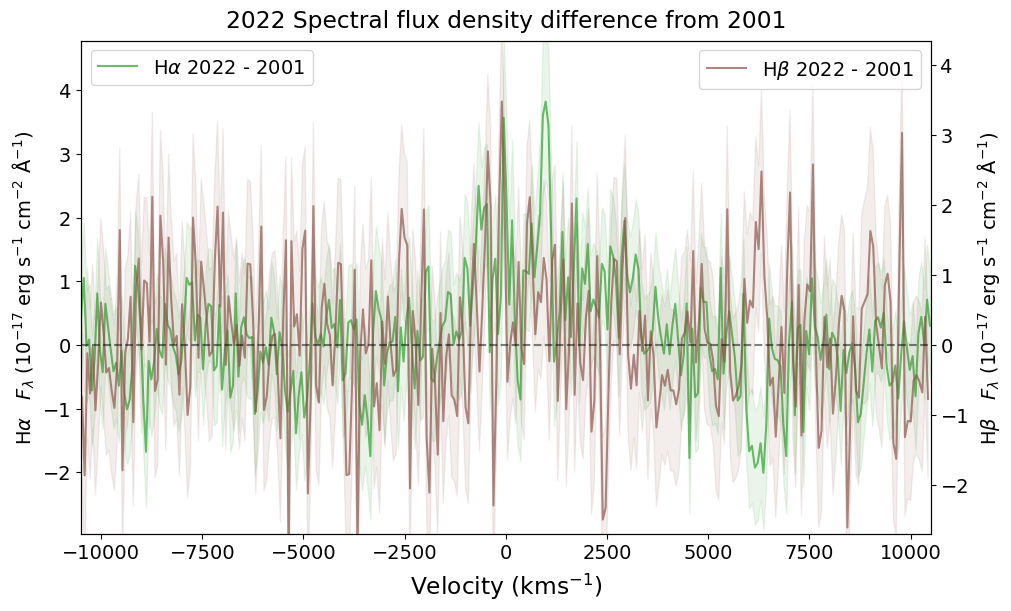

In [53]:
plotting.plot_diff_spectra_all(
    lam=lam,
    diff_15=diff_15,
    diff_15_err=diff_15_err,
    plot_y_bounds_list=[False],
    plot_centres_list=[[const.H_ALPHA, const.H_BETA]],
    plot_labels_list=[[r"H$\alpha$", r"H$\beta$"]],
    ions_list=[None],
    n_ticks_x_list=[None],
    scale_axes_list=[True],
    scale_all_axes=False,
    save_fig_name="diff_15_scaled_vel.pdf"
)
plotting.plot_diff_spectra_all(
    lam=lam,
    diff_21=diff_21,
    diff_21_err=diff_21_err,
    plot_y_bounds_list=[False],
    plot_centres_list=[[const.H_ALPHA, const.H_BETA]],
    plot_labels_list=[[r"H$\alpha$", r"H$\beta$"]],
    ions_list=[None],
    n_ticks_x_list=[None],
    scale_axes_list=[True],
    scale_all_axes=False,
    save_fig_name="diff_21_scaled_vel.pdf"
)
plotting.plot_diff_spectra_all(
    lam=lam,
    diff_22=diff_22,
    diff_22_err=diff_22_err,
    plot_y_bounds_list=[False],
    plot_centres_list=[[const.H_ALPHA, const.H_BETA]],
    plot_labels_list=[[r"H$\alpha$", r"H$\beta$"]],
    ions_list=[None],
    n_ticks_x_list=[None],
    scale_axes_list=[True],
    scale_all_axes=False,
    save_fig_name="diff_22_scaled_vel.pdf"
)

## Gaussian fitting


Mean bias: 0.259σ


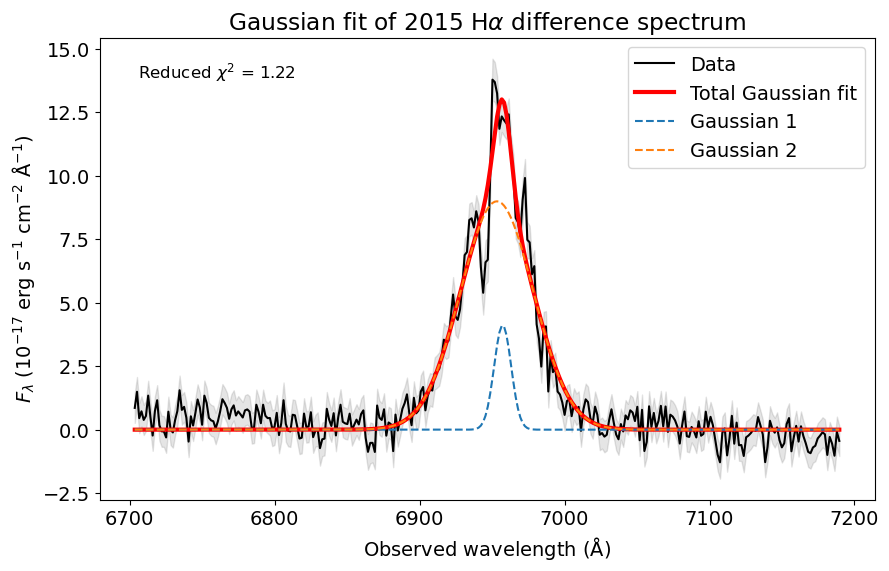

Mean bias: 0.238σ


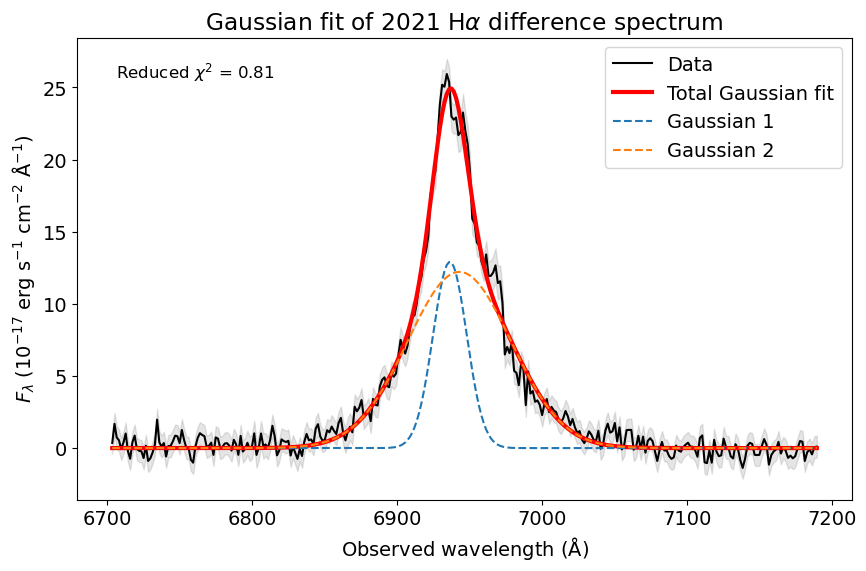

Mean bias: 0.248σ


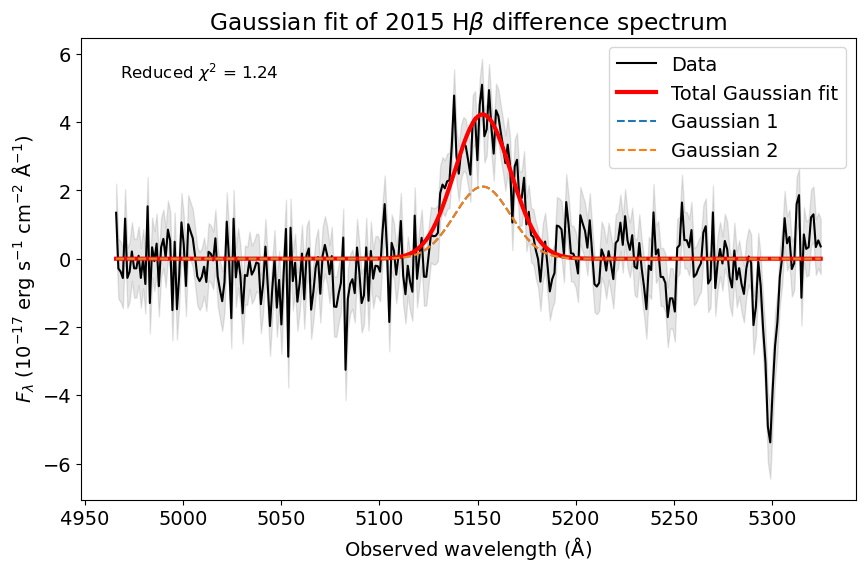

Mean bias: 0.229σ


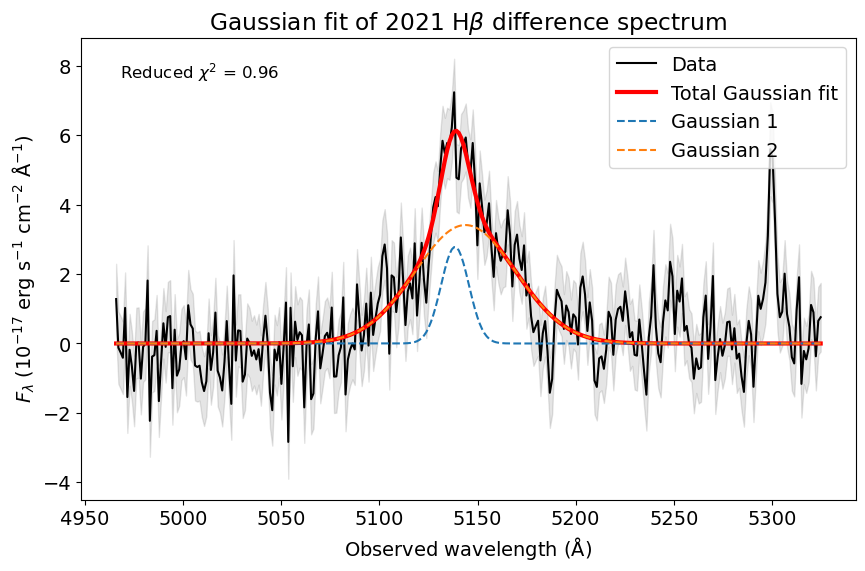

In [54]:
gaussian_fitting.fit_gaussians(
    x_untrimmed=lam,
    y_untrimmed=diff_15,
    y_errs_untrimmed=diff_15_err,
    mask_lam_centre=const.H_ALPHA,
    num_gaussians=const.DEFAULT_NUM_GAUSSIANS,
    n_mc_trials=const.TEST_NUM_MC_TRIALS,
    plot_fit=True,
    title=r"Gaussian fit of 2015 H$\alpha$ difference spectrum",
    save_fig_name="gauss_fit_15_h_alpha"
);
gaussian_fitting.fit_gaussians(
    x_untrimmed=lam,
    y_untrimmed=diff_21,
    y_errs_untrimmed=diff_21_err,
    mask_lam_centre=const.H_ALPHA,
    num_gaussians=const.DEFAULT_NUM_GAUSSIANS,
    n_mc_trials=const.TEST_NUM_MC_TRIALS,
    plot_fit=True,
    title=r"Gaussian fit of 2021 H$\alpha$ difference spectrum",
    save_fig_name="gauss_fit_21_h_alpha"
);
gaussian_fitting.fit_gaussians(
    x_untrimmed=lam,
    y_untrimmed=diff_15,
    y_errs_untrimmed=diff_15_err,
    mask_lam_centre=const.H_BETA,
    num_gaussians=const.DEFAULT_NUM_GAUSSIANS,
    n_mc_trials=const.TEST_NUM_MC_TRIALS,
    plot_fit=True,
    title=r"Gaussian fit of 2015 H$\beta$ difference spectrum",
    save_fig_name="gauss_fit_15_h_beta"
);
gaussian_fitting.fit_gaussians(
    x_untrimmed=lam,
    y_untrimmed=diff_21,
    y_errs_untrimmed=diff_21_err,
    mask_lam_centre=const.H_BETA,
    num_gaussians=const.DEFAULT_NUM_GAUSSIANS,
    n_mc_trials=const.TEST_NUM_MC_TRIALS,
    plot_fit=True,
    title=r"Gaussian fit of 2021 H$\beta$ difference spectrum",
    save_fig_name="gauss_fit_21_h_beta"
);


## Flux integration

In [55]:
num_gaussians_15_21 = 2
num_gaussians_22 = 0

h_alpha_lam_bounds = helpers.get_lam_bounds(const.H_ALPHA, const.VEL_TO_IGNORE_WIDTH, width_is_vel=True)
h_beta_lam_bounds = helpers.get_lam_bounds(const.H_BETA, const.VEL_TO_IGNORE_WIDTH, width_is_vel=True)

In [56]:
flux_alpha_15, flux_alpha_15_err, fwhm_mean_alpha_15, fwhm_err_alpha_15 = integrate.integrate_flux(
    lam=lam,
    spec_flux_density=diff_15,
    spec_flux_density_err=diff_15_err,
    lam_bounds=h_alpha_lam_bounds,
    num_gaussians=num_gaussians_15_21,
    n_mc_trials=const.TEST_NUM_MC_TRIALS,
    calculate_mean_fwhm=True,
    lam_centre=const.H_ALPHA,
    title="2015 Hα flux difference from 2001"
)
flux_alpha_21, flux_alpha_21_err, fwhm_mean_alpha_21, fwhm_err_alpha_21 = integrate.integrate_flux(
    lam=lam,
    spec_flux_density=diff_21,
    spec_flux_density_err=diff_21_err,
    lam_bounds=h_alpha_lam_bounds,
    num_gaussians=num_gaussians_15_21,
    n_mc_trials=const.TEST_NUM_MC_TRIALS,
    calculate_mean_fwhm=True,
    lam_centre=const.H_ALPHA,
    title="2021 Hα flux difference from 2001"
)
flux_alpha_22, flux_alpha_22_err, fwhm_mean_alpha_22, fwhm_err_alpha_22 = integrate.integrate_flux(
    lam=lam,
    spec_flux_density=diff_22,
    spec_flux_density_err=diff_22_err,
    lam_bounds=h_alpha_lam_bounds,
    num_gaussians=num_gaussians_22,
    n_mc_trials=const.TEST_NUM_MC_TRIALS,
    calculate_mean_fwhm=True,
    lam_centre=const.H_ALPHA
)

flux_beta_15, flux_beta_15_err, fwhm_mean_beta_15, fwhm_err_beta_15 = integrate.integrate_flux(
    lam=lam,
    spec_flux_density=diff_15,
    spec_flux_density_err=diff_15_err,
    lam_bounds=h_beta_lam_bounds,
    num_gaussians=num_gaussians_15_21,
    n_mc_trials=const.TEST_NUM_MC_TRIALS,
    calculate_mean_fwhm=True,
    lam_centre=const.H_BETA,
    title="2015 Hβ flux difference from 2001"
)
flux_beta_21, flux_beta_21_err, fwhm_mean_beta_21, fwhm_err_beta_21 = integrate.integrate_flux(
    lam=lam,
    spec_flux_density=diff_21,
    spec_flux_density_err=diff_21_err,
    lam_bounds=h_beta_lam_bounds,
    num_gaussians=num_gaussians_15_21,
    n_mc_trials=const.TEST_NUM_MC_TRIALS,
    calculate_mean_fwhm=True,
    lam_centre=const.H_BETA,
    title="2021 Hβ flux difference from 2001"
)
flux_beta_22, flux_beta_22_err, fwhm_mean_beta_22, fwhm_err_beta_22 = integrate.integrate_flux(
    lam=lam,
    spec_flux_density=diff_22,
    spec_flux_density_err=diff_22_err,
    lam_bounds=h_beta_lam_bounds,
    num_gaussians=num_gaussians_22,
    n_mc_trials=const.TEST_NUM_MC_TRIALS,
    calculate_mean_fwhm=True,
    lam_centre=const.H_BETA
)

In [57]:
print(f"2015 Hα FWHM: ({fwhm_mean_alpha_15:.2f} ± {fwhm_err_alpha_15:.2f}) km/s")
print(f"2021 Hα FWHM: ({fwhm_mean_alpha_21:.2f} ± {fwhm_err_alpha_21:.2f}) km/s")
print()
print(f"2015 Hβ FWHM: ({fwhm_mean_beta_15:.2f} ± {fwhm_err_beta_15:.2f}) Å")
print(f"2021 Hβ FWHM: ({fwhm_mean_beta_21:.2f} ± {fwhm_err_beta_21:.2f}) Å")
print()
print(
    f"2015 Hα flux difference from 2001: ({flux_alpha_15:.2f} ± {flux_alpha_15_err:.2f}) {const.FLUX_UNITS_NOT_LATEX}"+
    f"\t(calculated with {num_gaussians_15_21} Gaussians)"
)
print(
    f"2021 Hα flux difference from 2001: ({flux_alpha_21:.2f} ± {flux_alpha_21_err:.2f}) {const.FLUX_UNITS_NOT_LATEX}"+
    f"\t(calculated with {num_gaussians_15_21} Gaussians)"
)
print(
    f"2022 Hα flux difference from 2001: ({flux_alpha_22:.2f} ± {flux_alpha_22_err:.2f}) {const.FLUX_UNITS_NOT_LATEX}"+
    f"\t(calculated with {num_gaussians_22} Gaussians)"
)
print()
print(
    f"2015 Hβ flux difference from 2001: ({flux_beta_15:.2f} ± {flux_beta_15_err:.2f}) {const.FLUX_UNITS_NOT_LATEX}"+
    f"\t(calculated with {num_gaussians_15_21} Gaussians)"
)
print(
    f"2021 Hβ flux difference from 2001: ({flux_beta_21:.2f} ± {flux_beta_21_err:.2f}) {const.FLUX_UNITS_NOT_LATEX}"+
    f"\t(calculated with {num_gaussians_15_21} Gaussians)"
)
print(
    f"2022 Hβ flux difference from 2001: ({flux_beta_22:.2f} ± {flux_beta_22_err:.2f}) {const.FLUX_UNITS_NOT_LATEX}"+
    f"\t(calculated with {num_gaussians_22} Gaussians)"
)

2015 Hα FWHM: (1738.14 ± 124.01) km/s
2021 Hα FWHM: (1786.57 ± 59.62) km/s

2015 Hβ FWHM: (1964.56 ± 149.45) Å
2021 Hβ FWHM: (1872.07 ± 309.82) Å

2015 Hα flux difference from 2001: (625.30 ± 4.06) 10⁻¹⁷ erg s⁻¹ cm⁻²	(calculated with 2 Gaussians)
2021 Hα flux difference from 2001: (1442.89 ± 4.44) 10⁻¹⁷ erg s⁻¹ cm⁻²	(calculated with 2 Gaussians)
2022 Hα flux difference from 2001: (124.86 ± 15.61) 10⁻¹⁷ erg s⁻¹ cm⁻²	(calculated with 0 Gaussians)

2015 Hβ flux difference from 2001: (151.07 ± 2.72) 10⁻¹⁷ erg s⁻¹ cm⁻²	(calculated with 2 Gaussians)
2021 Hβ flux difference from 2001: (264.16 ± 3.13) 10⁻¹⁷ erg s⁻¹ cm⁻²	(calculated with 2 Gaussians)
2022 Hβ flux difference from 2001: (25.01 ± 13.62) 10⁻¹⁷ erg s⁻¹ cm⁻²	(calculated with 0 Gaussians)


Comparison with photometry values

In [58]:
helpers.pretty_print_flux_comparison(
    flux_alpha_21, flux_alpha_21_err, num_gaussians_15_21,
    flux_alpha_22, flux_alpha_22_err, num_gaussians_22,
    flux_beta_21, flux_beta_21_err, num_gaussians_15_21,
    flux_beta_22, flux_beta_22_err, num_gaussians_22
) #TODO: check error calculation

Survey                  | Photometric Flux (μJy) | Integrated Spectroscopic Flux (μJy)^ | Number of Gaussians used to integrate
---------------------------------------------------------------------------------------------------------------------------------
ASASSN g band 2021 (Hβ) | -17.2000               | (1.806 ± 0.021)                      |                   2                  
ASASSN g band 2022 (Hβ) | -30.1000               | (0.171 ± 0.093)                      |                   0                  
Atlas o band 2021 (Hα)  |  52.6000               | (8.934 ± 0.027)                      |                   2                  
Atlas o band 2022 (Hα)  | -6.1000                | (0.773 ± 0.097)                      |                   0                  
ZTF r band 2021 (Hα)    |  4.9000                | (14.561 ± 0.045)                     |                   2                  
ZTF r band 2022 (Hα)    | -22.9000               | (1.260 ± 0.158)                      |             

## Balmer decrements

Mean bias: 0.422σ


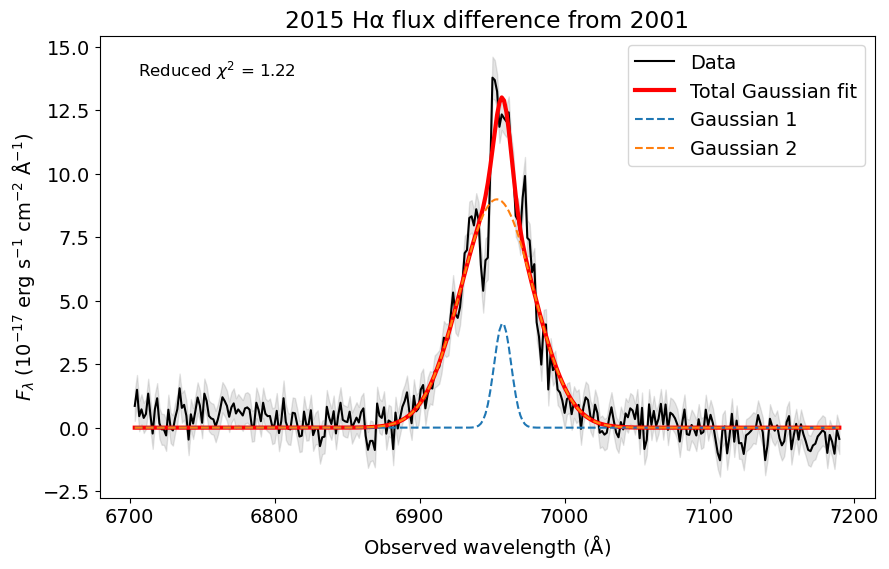

Mean bias: 0.212σ


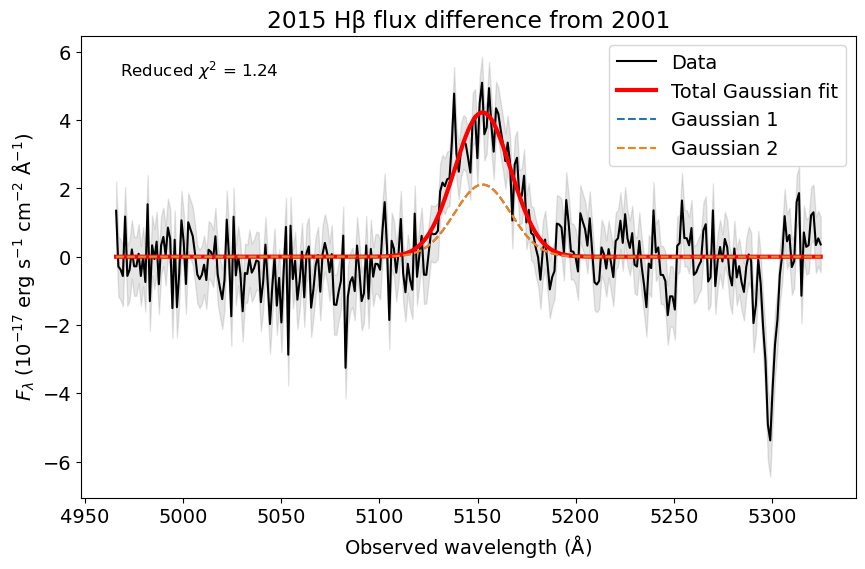

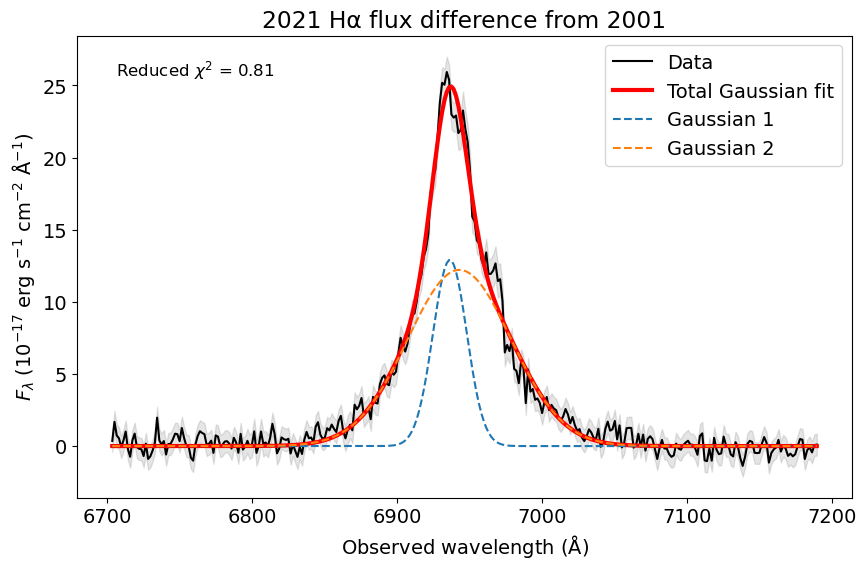

Mean bias: 0.190σ


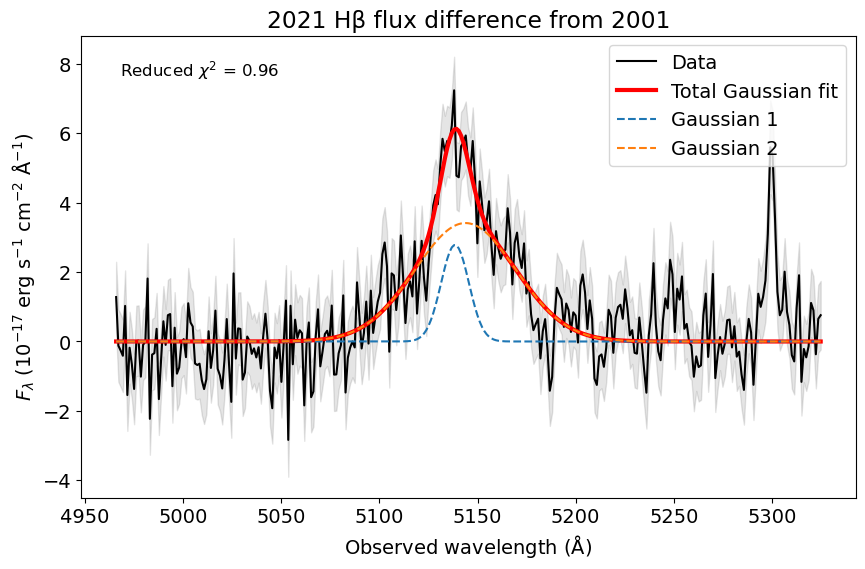

-----------------------------------------------------
Results: (calculated with 2 Gaussians and no binning)
-----------------------------------------------------
2015 Balmer decrement: 4.14 ± 0.07
2021 Balmer decrement: 5.46 ± 0.06


In [59]:
bd_15_arr, bd_15_arr_err, _ = integrate.calculate_balmer_decrement(
    lam,
    diff_15,
    diff_15_err,
    vel_integration_width=const.VEL_TO_IGNORE_WIDTH,
    vel_gaussian_fit_width=const.VEL_WIDTH_GAUSSIAN_FIT,
    vel_plot_width=const.VEL_PLOT_WIDTH,
    num_gaussians=num_gaussians_15_21,
    num_bins=1,
    year=2015,
    n_mc_trials=const.TEST_NUM_MC_TRIALS
)
bd_21_arr, bd_21_arr_err, _ = integrate.calculate_balmer_decrement(
    lam,
    diff_21,
    diff_21_err,
    vel_integration_width=const.VEL_TO_IGNORE_WIDTH,
    vel_gaussian_fit_width=const.VEL_WIDTH_GAUSSIAN_FIT,
    vel_plot_width=const.VEL_PLOT_WIDTH,
    num_gaussians=num_gaussians_15_21,
    num_bins=1,
    year=2021,
    n_mc_trials=const.TEST_NUM_MC_TRIALS
)
res_header = f"Results: (calculated with {num_gaussians_15_21} Gaussians and no binning)"
print("-"*len(res_header))
print(res_header)
print("-"*len(res_header))
print(f"2015 Balmer decrement: {bd_15_arr[0]:.2f} ± {bd_15_arr_err[0]:.2f}")
print(f"2021 Balmer decrement: {bd_21_arr[0]:.2f} ± {bd_21_arr_err[0]:.2f}")


Balck hole mass calculation

In [60]:
lum_alpha_15, lum_err_alpha_15 = bh_mass.get_luminosity(flux_alpha_15, flux_alpha_15_err)
lum_alpha_21, lum_err_alpha_21 = bh_mass.get_luminosity(flux_alpha_21, flux_alpha_21_err)
bh_mass_15, bh_mass_err_15 = bh_mass.get_bh_mass(lum_alpha_15, lum_err_alpha_15, fwhm_mean_alpha_15, fwhm_err_alpha_15)
bh_mass_21, bh_mass_err_21 = bh_mass.get_bh_mass(lum_alpha_21, lum_err_alpha_21, fwhm_mean_alpha_21, fwhm_err_alpha_21)

In [61]:
helpers.compare_yasmeen_results(
    fwhm_alpha_15=(fwhm_mean_alpha_15, fwhm_err_alpha_15),
    fwhm_alpha_21=(fwhm_mean_alpha_21, fwhm_err_alpha_21),
    fwhm_beta_15=(fwhm_mean_beta_15, fwhm_err_beta_15),
    fwhm_beta_21=(fwhm_mean_beta_21, fwhm_err_beta_21),
    flux_alpha_15=(flux_alpha_15, flux_alpha_15_err),
    flux_alpha_21=(flux_alpha_21, flux_alpha_21_err),
    luminosity_alpha_15=(lum_alpha_15*1e-40, lum_err_alpha_15*1e-40),
    luminosity_alpha_21=(lum_alpha_21*1e-40, lum_err_alpha_21*1e-40),
    bd_15=(bd_15_arr[0], bd_15_arr_err[0]),
    bd_21=(bd_21_arr[0], bd_21_arr_err[0]),
    bh_mass_15=(bh_mass_15*1e-6, bh_mass_err_15*1e-6),
    bh_mass_21=(bh_mass_21*1e-6, bh_mass_err_21*1e-6)
)

                                    | Most recent results  | SSP results         
---------------------------------------------------------------------------------
FWHM Hα 2015 (km/s)                 | 1738.14 ± 124.01     | 2143.00 ± 60.00     
FWHM Hα 2021 (km/s)                 | 1786.57 ± 59.62      | 2097.00 ± 365.00    
FWHM Hβ 2015 (km/s)                 | 1964.56 ± 149.45     | 1731.00 ± 394.00    
FWHM Hβ 2021 (km/s)                 | 1872.07 ± 309.82     | 1759.00 ± 292.00    
Flux Hα 2015 (1e-17 ergs/s/cm^2)    | 625.30 ± 4.06        | 635.00 ± 22.00      
Flux Hα 2021 (1e-17 ergs/s/cm^2)    | 1442.89 ± 4.44       | 2330.00 ± 40.00     
Luminosity Hα 2015 (1e40 ergs/s)    | 5.65 ± 0.04          | 5.49 ± 0.19         
Luminosity Hα 2021 (1e40 ergs/s)    | 13.04 ± 0.04         | 20.10 ± 0.30        
Balmer decrement Hα 2015            | 4.14 ± 0.07          | 4.58 ± 1.69         
Balmer decrement Hα 2021            | 5.46 ± 0.06          | 7.68 ± 2.57         
BH mass 2015 (1e

Comparing balmer decrement calculations based on number of gaussians and binning

In [62]:
(
    bd_results_15, num_gaussians_list_15,
    num_bins_list_15
) = integrate.get_bd_comparison_info(
    lam, diff_15, diff_15_err,
    num_bins_bounds=(1, 5),
    num_gaussians_bounds=(0, 0),
    vel_integration_width=const.VEL_TO_IGNORE_WIDTH,
    vel_gaussian_fit_width=const.VEL_WIDTH_GAUSSIAN_FIT,
    vel_plot_width=const.VEL_PLOT_WIDTH,
    n_mc_trials=const.TEST_NUM_MC_TRIALS,
    print_progress=True
)

Calculating balmer decrements for 0/0 Gaussians
1/5 bins (of 0 gaussians)
2/5 bins (of 0 gaussians)
3/5 bins (of 0 gaussians)
4/5 bins (of 0 gaussians)
5/5 bins (of 0 gaussians)


In [63]:
(
    bd_results_21, num_gaussians_list_21,
    num_bins_list_21
) = integrate.get_bd_comparison_info(
    lam, diff_21, diff_21_err,
    num_bins_bounds=(1, 5),
    num_gaussians_bounds=(0, 0),
    vel_integration_width=const.VEL_TO_IGNORE_WIDTH,
    vel_gaussian_fit_width=const.VEL_WIDTH_GAUSSIAN_FIT,
    vel_plot_width=const.VEL_PLOT_WIDTH,
    n_mc_trials=const.TEST_NUM_MC_TRIALS,
    print_progress=True
)

Calculating balmer decrements for 0/0 Gaussians
1/5 bins (of 0 gaussians)
2/5 bins (of 0 gaussians)
3/5 bins (of 0 gaussians)
4/5 bins (of 0 gaussians)
5/5 bins (of 0 gaussians)


In [64]:
mean_bd_15_no_bin = plotting.compare_balmer_decrements(
    bd_results_15,
    num_gaussians_list_15,
    num_bins_list_15,
    year=2015,
    ylim=(-5, 17),

    # lam=lam,
    # diff_15=diff_15,
    # diff_15_err=diff_15_err,
    # plot_y_bounds=(-5, 17),
    # make_new_fig=False
)

In [65]:
mean_bd_21_no_bin = plotting.compare_balmer_decrements(
    bd_results_21,
    num_gaussians_list_21,
    num_bins_list_21,
    year=2021
)